# Fitting the data: Part 1

This tutorial will focus on the most important feature of the `pyMultiFit` library, model fitting.

## `BaseFitter`

Like **distributions**, the **fitters** module also provides a handy `BaseFitter` class for generating a child fitter.
The `BaseFitter` accepts three arguments and one additional class parameter.

1. `x_values`: The x-values of the data,
2. `y_values`: The y-values of the data,
3. `max_iterations`: The maximum number of iterations that the minimizer should follow, and
4. `n_par`: The number of parameters in the distribution.

It also requires the user to define two methods,

1. `fit_boundaries()`: It tells the class to keep track of the parameter boundaries.
2. `fitter(x, params)`: The function that can fit the data, e.g., PDF in case of any distribution.


<div class="alert alert-block alert-warning">In case the user doesn't define the boundaries for parameters in the `fit_boundaries()` function, by default `-np.inf` and `np.inf` will be used as lower and upper boundaries, which might not be suitable in all cases. Thus, the user is urged to define the boundaries in the `fit_boundaries()` function.</div>

The user **must** provide the `fitter` function, if not both.

## Data generation

Let's regenerate some normalized multi-Gaussian data with $\mu = [-20, -5.5, -1, 3, 15]$ and $\sigma = [2, 5, 0.5, 1, 3]$.
For this, we can either define our custom Gaussian class or use the ones provided in the **distributions** module.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Let's create the parameter lists and get them stacked.
When using internal `GaussianDistribution` is it important to note that it uses three parameters instead of two.

1. `amplitude`: Amplitude, in case of non-normalized distribution generation, $A$.
2. `mean`: The mean value, $\mu$.
3. `std`: The standard deviation of the Gaussian, $\sigma$.

For now, since we're generating normalized Gaussian distributions, and include a nice $\mathcal{N}(0, 0.01)$ noise in it as well.

For any normalized distribution, the `normlize` keyword must be set to `True` whether or not the amplitude is set to 1.
This is because the `normalize` keyword handles the amplitude logic internally.

In [2]:
amplitude = [1, 20, 1, 1, 1]
mu = [-20, -5.5, -1, 3, 15]
sigma = [2, 5, 0.5, 1, 3]

noise_level = 0.01
parameters = np.column_stack([amplitude, mu, sigma])

x_vals = np.linspace(-35, 35, 1500)

The multi-Gaussian data can also be generated by using the `multi_gaussian` function from the **generators** module.
This removes the need to pass the custom distribution class into the `multi_base` function.

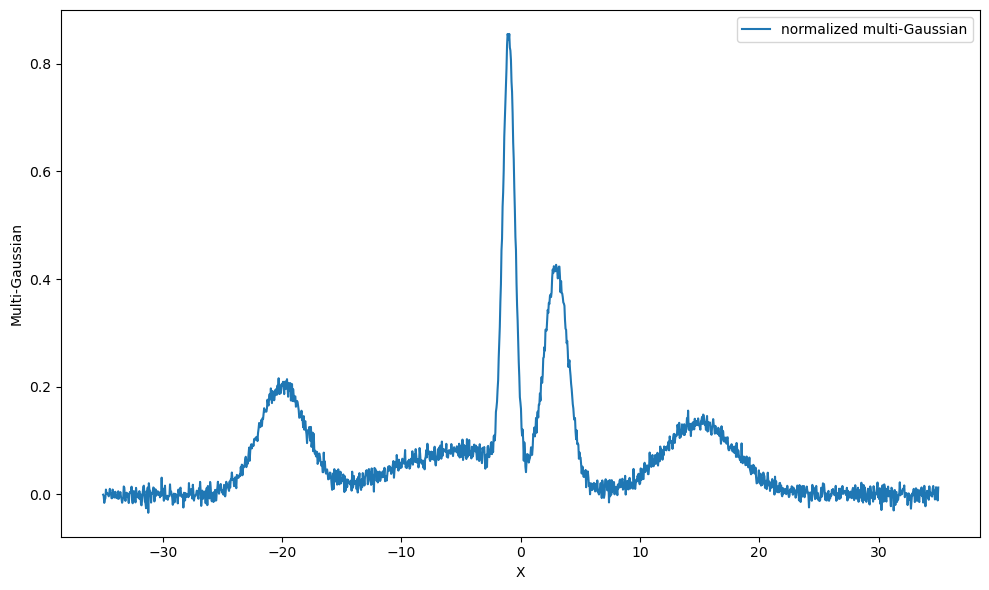

In [3]:
from pymultifit.generators import multi_gaussian

y_gaussian = multi_gaussian(x_vals, params=parameters, noise_level=noise_level, normalize=True)

plt.figure(figsize=(10, 6))

plt.plot(x_vals, y_gaussian, label='normalized multi-Gaussian')
plt.xlabel('X')
plt.ylabel('Multi-Gaussian')
plt.legend()
plt.tight_layout()
plt.show()

We see here that even though we set the second amplitude parameter to be $20$, it didn't scale it because the generator was asked to generate normalized distribution.

## Data fitting

Let's generate a custom fitter using `BaseFitter` class.
The `pyMultiFit` also provides **PDF** and **CDF** functionalities of several distributions via the `pymultifit.distributions.utilities_d` module.

In [4]:
from pymultifit.fitters.backend import BaseFitter
from pymultifit.distributions.utilities_d import gaussian_pdf_


class CustomFitter(BaseFitter):

    def __init__(self, x_values, y_values, max_iterations: int = 1000):
        super().__init__(x_values=x_values, y_values=y_values, max_iterations=max_iterations)

        # since we're making a Gaussian fitter using pyMultiFit GaussianDistribution,
        # we need three parameters, amplitude, mu, std
        self.n_par = 3

    @staticmethod
    def fit_boundaries():
        lb = (0, -np.inf, 0)
        ub = (np.inf, np.inf, np.inf)

        return lb, ub

    @staticmethod
    def fitter(x, params):
        return gaussian_pdf_(x, *params, normalize=False)

The boundaries are in the same order as those of the input parameters, $A$, $\mu$, and $\sigma$.
These are used during the fitting process by `scipy.optimize.curve_fit`.

Now to fit the data, we pass the x and y values of the data to the custom fitting class we've made.

In [5]:
cf = CustomFitter(x_vals, y_gaussian)

Before fitting the data, it can also be visualized via the `dry_run` method to make some guesses about the parameters.

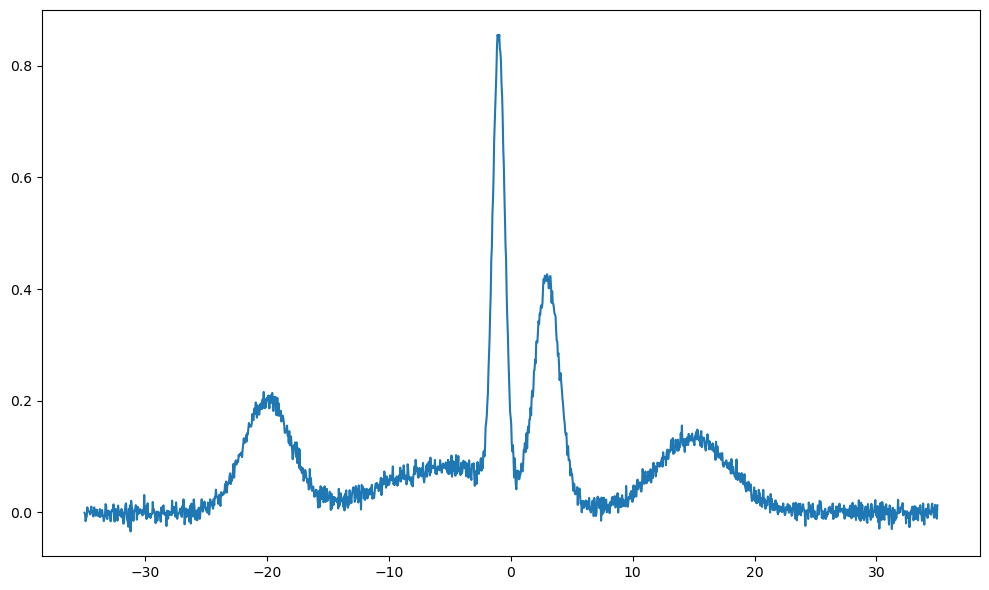

In [6]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
cf.dry_run(axis=ax)

From the plot, we can make some guesses about the parameters

In [7]:
amp_guess = [0.2, 0.1, 0.8, 0.4, 0.1]
mu_guess = [-20, -5, -1, 1, 15]
std_guess = [1, 5, 0.1, 0.1, 0.5]

guesses = np.column_stack([amp_guess, mu_guess, std_guess])

The guesses values are than fed to the `fit` function of the custom fitter.
The fitted data can be visualized via the `plot_fit` function.

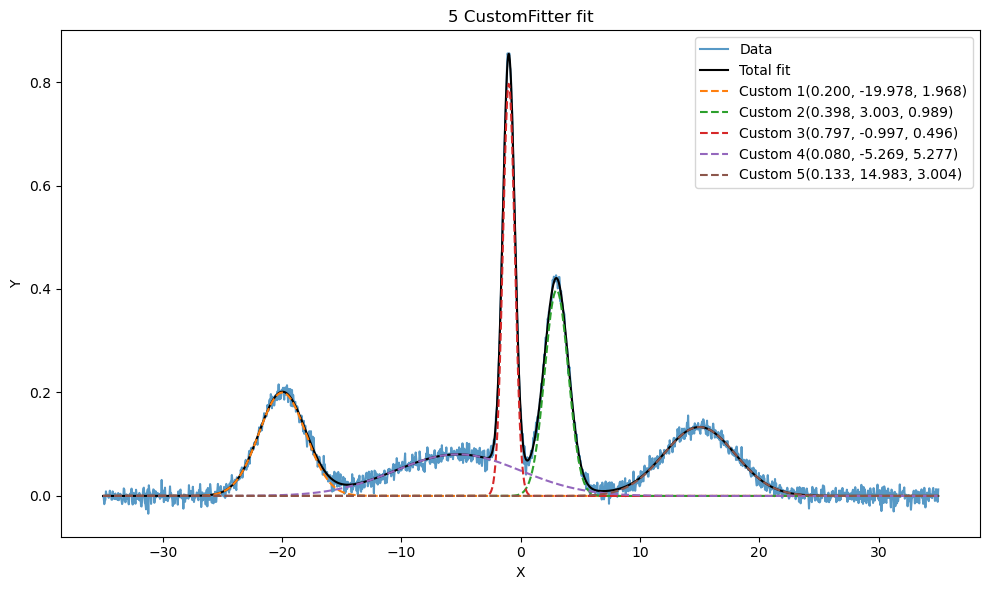

In [8]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

cf.fit(guesses)
plotter = cf.plot_fit(show_individuals=True, axis=ax)

The fitting legends are the result of the `show_individual` parameter.
The labels present the parameters in the same order as the distribution, $A$, $\mu$, and $\sigma$.
The amplitude for a normalized distribution is the normalization factor.
In case of Gaussian distribution, the amplitude parameter can also be calculated as,

$$
A = \dfrac{1}{\sqrt{2\pi\sigma^2}}
$$

The output of the `plot_fit` function is an `plt.axes.Axis` object that can later be used to apply labels, etcetera if required.